In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
import re
from tensorflow.keras.regularizers import l2

In [2]:
df_train = pd.read_csv('./dataset/twitter_training.csv', header=None)
df_valid = pd.read_csv('./dataset/twitter_validation.csv', header=None)

In [3]:
df_train.columns = ['ID', 'Name', 'Label', 'Content']
df_valid.columns = ['ID', 'Name', 'Label', 'Content']

df_train

,ID,Name,Label,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [27]:
df_train['Label'].value_counts() / len(df_train)

Label
Neutral     0.422086
Negative    0.302808
Positive    0.275106
Name: count, dtype: float64

In [4]:
missing_values_train = df_train.isnull().sum()
missing_values_percent_train = (df_train.isnull().sum()) / (len(df_train))
duplicated_values_train = df_train.duplicated().sum()
duplicated_values_percent_train = (df_train.duplicated().sum() / (len(df_train)))

missing_values_valid = df_valid.isnull().sum()
missing_values_percent_valid = (df_valid.isnull().sum()) / (len(df_valid))
duplicated_values_valid = df_valid.duplicated().sum()
duplicated_values_percent_valid = (df_valid.duplicated().sum() / (len(df_valid)))

explain_df = pd.DataFrame({'Missed_values_train': missing_values_train, 'Missed_values_%_train':missing_values_percent_train, 
                          'Duplicated_values_train': duplicated_values_train, 'Duplicated_values_%_train': duplicated_values_percent_train,
                          'Missed_values_valid': missing_values_valid, 'Missed_values_%_valid':missing_values_percent_valid, 
                          'Duplicated_values_valid': duplicated_values_valid, 'Duplicated_values_%_valid': duplicated_values_percent_valid})

explain_df

,Missed_values_train,Missed_values_%_train,Duplicated_values_train,Duplicated_values_%_train,Missed_values_valid,Missed_values_%_valid,Duplicated_values_valid,Duplicated_values_%_valid
ID,0,0.000000,2700,0.036153,0,0.0,0,0.0
Name,0,0.000000,2700,0.036153,0,0.0,0,0.0
Label,0,0.000000,2700,0.036153,0,0.0,0,0.0
Content,686,0.009186,2700,0.036153,0,0.0,0,0.0


In [5]:
df_train.dropna(inplace=True)
df_train.drop_duplicates(inplace=True)

In [6]:
df_train['Label'] = df_train['Label'].replace('Irrelevant', 'Neutral')
df_valid['Label'] = df_valid['Label'].replace('Irrelevant', 'Neutral')

In [7]:
df_train['Label'].value_counts()

Label
Neutral     30245
Negative    21698
Positive    19713
Name: count, dtype: int64

In [8]:
label_mapping = {'Positive':0, 'Negative':1, 'Neutral':2}
train_label = df_train['Label'].map(label_mapping)
valid_label = df_valid['Label'].map(label_mapping)

In [9]:
def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols 
                           u"\U0001F680-\U0001F6FF"  # transport 
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tx)

def text_cleaner(tx):
    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    return text

In [10]:
df_train['Content'] = df_train['Content'].apply(lambda x: clean_emoji(x))
df_train['Content'] = df_train['Content'].apply(lambda x: text_cleaner(x))

df_valid['Content'] = df_valid['Content'].apply(lambda x: clean_emoji(x))
df_valid['Content'] = df_valid['Content'].apply(lambda x: text_cleaner(x))

In [11]:
lb = LabelBinarizer()

train_label = lb.fit_transform(train_label)
valid_label = lb.transform(valid_label)

In [12]:
print(train_label[0])
print(valid_label[0])

[1 0 0]
[0 0 1]


In [13]:
vocabulary_size = 10000

embedding_dim = 64

max_length_sentence = 150

In [14]:
tokenizer = Tokenizer(num_words=vocabulary_size, oov_token='OOV', lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

tokenizer.fit_on_texts(df_train['Content'])

In [15]:
print(list(tokenizer.word_index.items())[:50])

[('OOV', 1), ('the', 2), ('i', 3), ('to', 4), ('and', 5), ('is', 6), ('a', 7), ('of', 8), ('it', 9), ('in', 10), ('for', 11), ('this', 12), ('you', 13), ('not', 14), ('on', 15), ('my', 16), ('that', 17), ('com', 18), ('with', 19), ('have', 20), ('game', 21), ('so', 22), ('be', 23), ('are', 24), ('me', 25), ('just', 26), ('all', 27), ('but', 28), ('was', 29), ('at', 30), ('can', 31), ('do', 32), ('am', 33), ('like', 34), ('out', 35), ('we', 36), ('2', 37), ('from', 38), ('your', 39), ('they', 40), ('now', 41), ('s', 42), ('t', 43), ('will', 44), ('get', 45), ('as', 46), ('pic', 47), ('twitter', 48), ('has', 49), ('if', 50)]


In [16]:
df_train['Content'] = tokenizer.texts_to_sequences(df_train['Content'])

In [17]:
df_train['Content'][0]

[360, 168, 15, 137, 5, 3, 44, 1749, 13, 27]

In [18]:
padding_train_sentences = pad_sequences(df_train['Content'], maxlen= max_length_sentence, truncating= 'post', padding= 'post')

padding_train_sentences

array([[ 360,  168,   15, ...,    0,    0,    0],
       [   3,   33,  396, ...,    0,    0,    0],
       [ 360,  168,   15, ...,    0,    0,    0],
       ...,
       [  26, 1927,    2, ...,    0,    0,    0],
       [  26, 1927,  730, ...,    0,    0,    0],
       [  26,   34,    2, ...,    0,    0,    0]])

In [19]:
padding_train_sentences.shape

(71656, 150)

In [20]:
df_valid['Content'] = tokenizer.texts_to_sequences(df_valid['Content'])
padding_valid_sentences = pad_sequences(df_valid['Content'], maxlen= max_length_sentence, truncating= 'post', padding= 'post')

In [21]:
padding_valid_sentences.shape

(1000, 150)

In [51]:
inputs = Input(shape=(max_length_sentence,))  

x = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim)(inputs)
x = Flatten()(x)
x = Dense(10, activation='relu', kernel_regularizer=l2(0.005))(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 150, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        96,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 736,043 (2.81 MB)

 Trainable params: 736,043 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history = model.fit(padding_train_sentences, train_label, epochs=15, batch_size=32, validation_data=(padding_valid_sentences, valid_label))

Epoch 1/15
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.5535 - loss: 0.9435 - val_accuracy: 0.8440 - val_loss: 0.5131
Epoch 2/15
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8136 - loss: 0.5578 - val_accuracy: 0.9320 - val_loss: 0.3023
Epoch 3/15
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8960 - loss: 0.3738 - val_accuracy: 0.9640 - val_loss: 0.2200
Epoch 4/15
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9312 - loss: 0.2741 - val_accuracy: 0.9730 - val_loss: 0.1753
Epoch 5/15
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9445 - loss: 0.2206 - val_accuracy: 0.9740 - val_loss: 0.1539
Epoch 6/15
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9541 - loss: 0.1847 - val_accuracy: 0.9770 - val_loss: 0.1428
Epoch 7/15
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9583 - loss: 0.1633 - val_accuracy: 0.9730 - val_loss: 0.1380
Epoch 8/15
2240/2240 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9598 - loss: 0

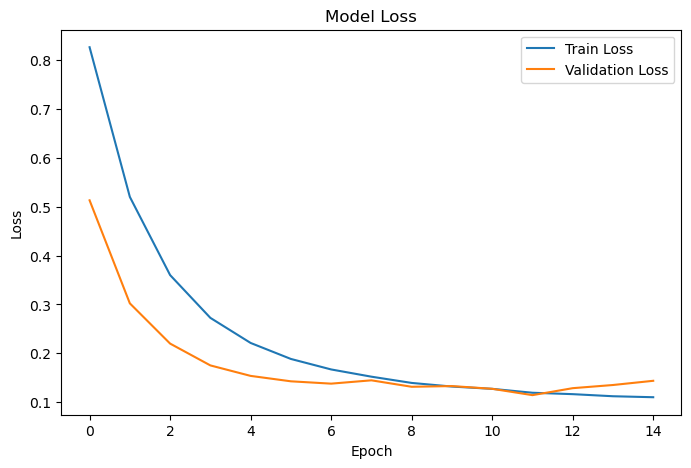

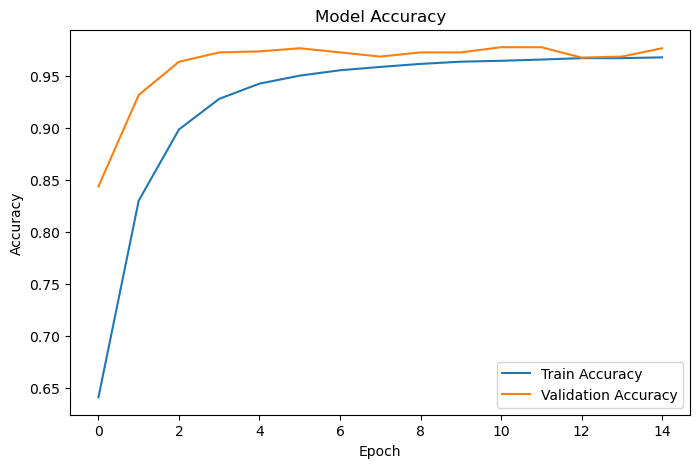

In [53]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(history.history.get('loss', []), label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()